In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ormachine
import pandas as pd
import seaborn as sns
from scipy.special import expit, logit
from importlib import reload
reload(ormachine)
import os

cmap3 = sns.cubehelix_palette(
        8, start=2, dark=0, light=1,
        reverse=False, as_cmap=True)

### Load data

In [2]:
genotype = pd.read_csv('./../data/pancan/genotye.csv', index_col=0) # genes x patients
genotype = genotype > 0

pathways = pd.read_csv('./../data/pancan/pathways.csv', index_col=0) # pathway x genes
labels = pd.read_csv('./../data/pancan/labels.csv', index_col=0) # disease x patients

pw_sample = pd.read_csv('./../data/pancan/pw_sample.csv', index_col=0) # pathway x patients (with labels)
pw_sample.columns=[x.split('.')[0] for x in pw_sample.columns]

dis_abbrev = np.load('./../data/pancan/dis_abbrev.npy') # list of disease names with abbreviations
dis_abbrev = [(str(x[0].decode("utf-8")),str(x[1].decode("utf-8"))) for x in dis_abbrev] # cast to list of tuples

## Supervised
### specify model architecture

In [137]:
reload(ormachine)

# create machine instance
orm = ormachine.machine()

# add patient-pathway matrix
patient_pws = orm.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1 = orm.add_layer(child = patient_pws, 
                       lbda_init=2,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1.z.sampling_indicator = False
layer1.u.sampling_indicator = False

# add latent layer
layer2 = orm.add_layer(size=25, 
                       child=patient_pws, 
                       lbda_init=1.7,
                       u_prior=.1)

# add disease encoding layer
layer3 = orm.add_layer(child=layer2.z, 
                       z_init=np.array(2*labels.as_matrix().transpose()-1, dtype=np.int8),
                       lbda_init=2.0)
layer3.z.sampling_indicator = False

### run inference

In [138]:
orm.infer(burn_in_min=int(2e3), burn_in_max=int(1e4), convergence_window=15,
          convergence_eps=5e-5, no_samples=int(1e2), print_step=5, fix_lbda_iters=25)

burning in markov chain...
	iteration: 2120 recon acc.: 0.947, 0.934, 0.896
	converged at reconstr. accuracy: 0.947, 0.934, 0.896
allocating memory to save samples...
drawing samples...
	iteration 100; recon acc.: 0.948, 0.934, 0.895
finished.


### plot results

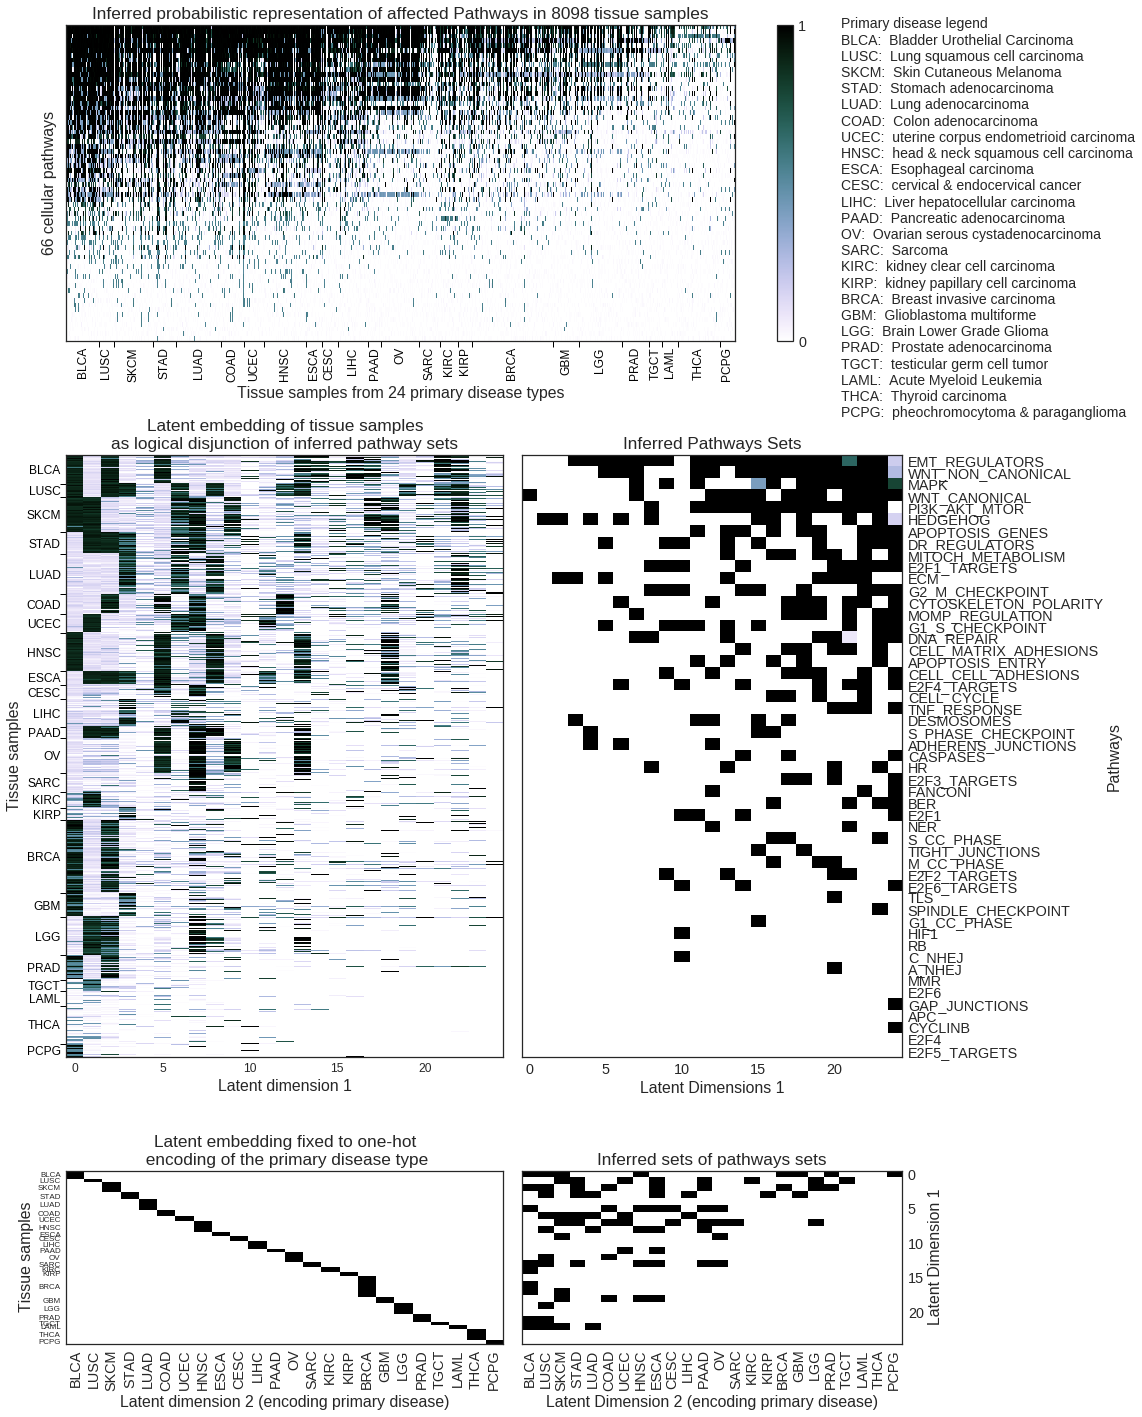

In [140]:
# genotype, pathways, labels
import tammo_lib as tl
reload(tl)
fig = tl.pancan_pws_2layer(
    patient_pws, layer2, layer3,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=50)

- Implement special case with two parents
- For three parents pass list to cython and unpack (https://stackoverflow.com/questions/29223179/how-to-pass-a-list-of-numpy-ndarrays-as-a-vector-to-cython)

## Unsupervised analysis

Now allow representations to have arbitrarily many codes

burning in markov chain...
	iteration: 625 recon acc.: 0.986, 0.816
	converged at reconstr. accuracy: 0.986, 0.816
allocating memory to save samples...
drawing samples...
	iteration 50; recon acc.: 0.987, 0.815
finished.


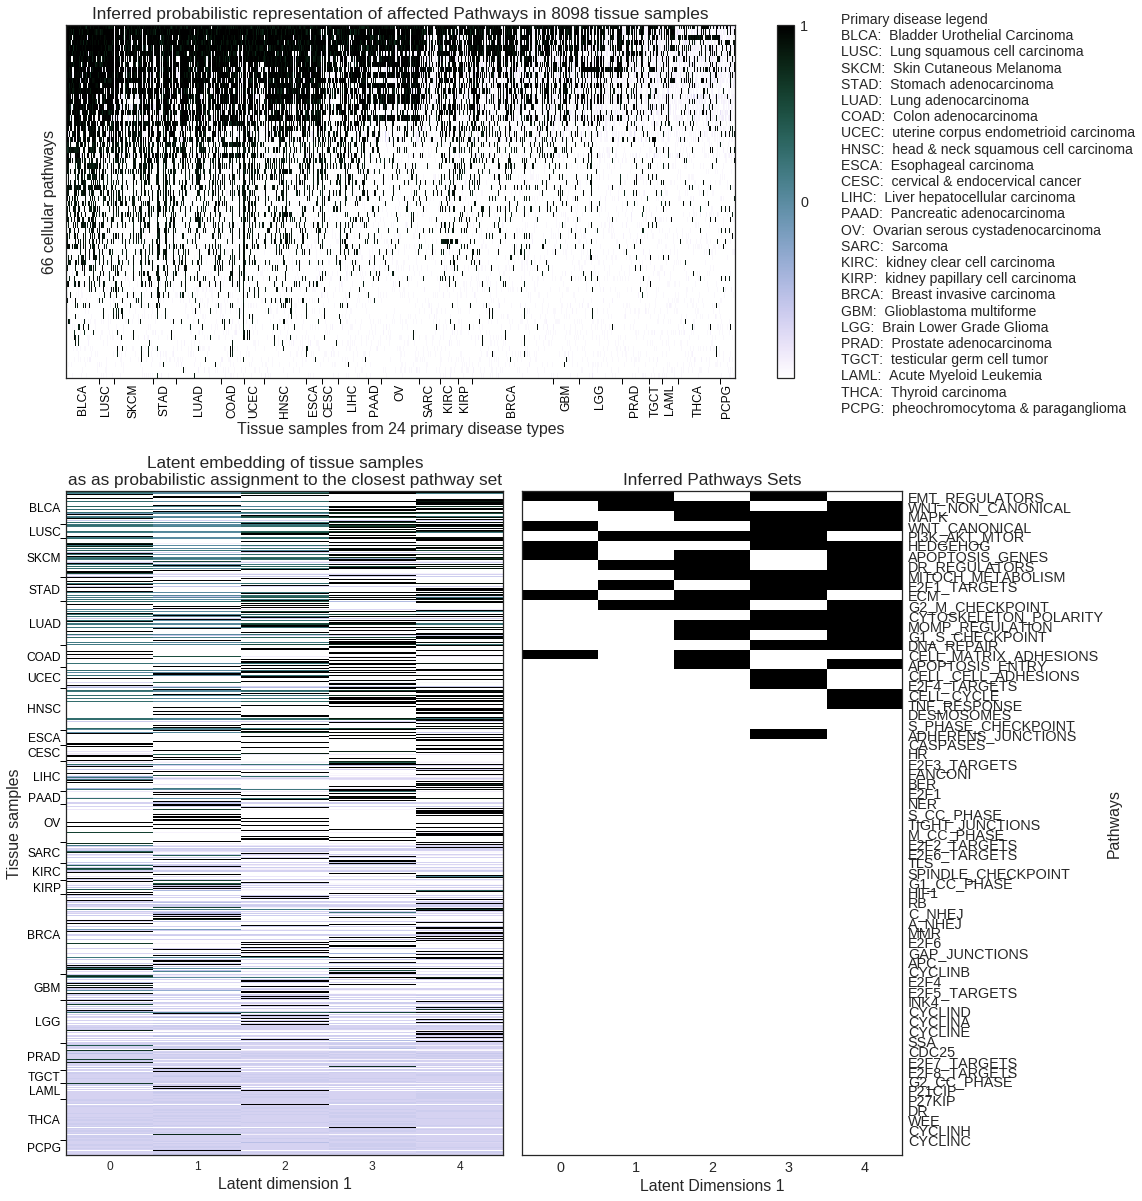

In [94]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=1.4,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=5, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5,
                         z_density_conditions=[1,0,0,0], u_density_conditions=[0,1,3,0]) # [1,0,0,0], [0,1,3,0] is nice

orm_2.infer(burn_in_min=100, burn_in_max=int(1e3), convergence_window=15,
          convergence_eps=2e-4, no_samples=int(5e1), print_step=5, fix_lbda_iters=30)

import tammo_lib as tl
reload(tl)
fig, ax = tl.pancan_pws_1layer(
    patient_pws_2, layer1_2, layer2_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)

Now each pw can appear in one code only and repsentations are one-hot

burning in markov chain...
	iteration: 1000 recon acc.: 0.967, 0.806
	max burn-in iterations reached without convergence
allocating memory to save samples...
drawing samples...
	iteration 50; recon acc.: 0.968, 0.803
finished.


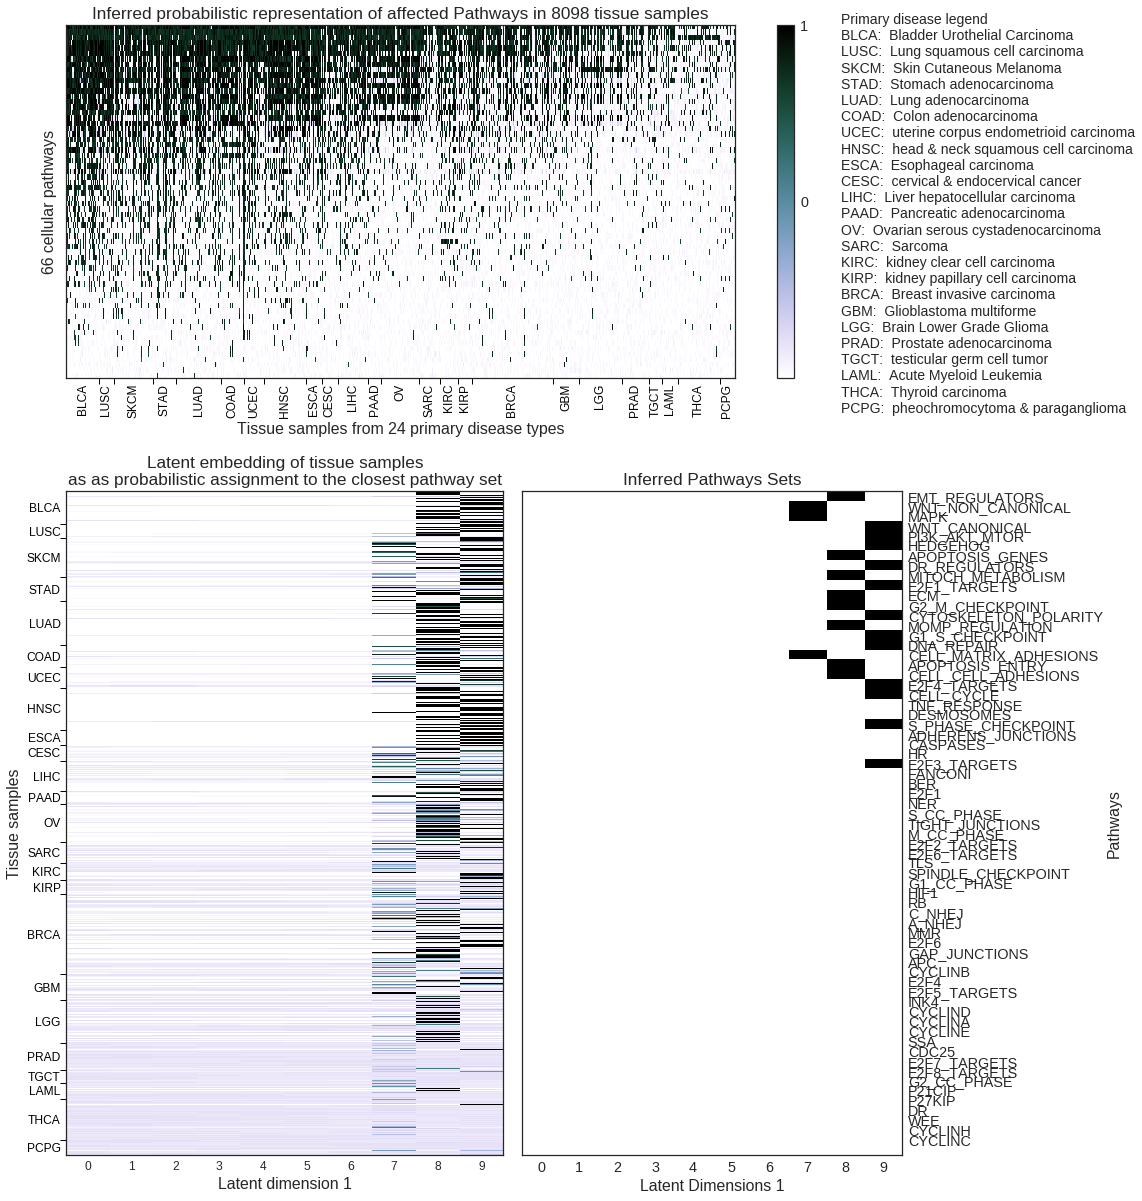

In [141]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=1.4,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=10, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5,
                         z_density_conditions=[1,0,1,0], u_density_conditions=[0,0,1,0]) # [1,0,0,0], [0,1,3,0] is nice

orm_2.infer(burn_in_min=100, burn_in_max=int(1e3), convergence_window=15,
          convergence_eps=2e-4, no_samples=int(5e1), print_step=5, fix_lbda_iters=30)

import tammo_lib as tl
reload(tl)
fig, ax = tl.pancan_pws_1layer(
    patient_pws_2, layer1_2, layer2_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)

Now each pw can appear in two code only (2/5) and repsentations are one-hot

burning in markov chain...
	iteration: 805 recon acc.: 0.979, 0.814
	converged at reconstr. accuracy: 0.979, 0.814
allocating memory to save samples...
drawing samples...
	iteration 50; recon acc.: 0.981, 0.811
finished.


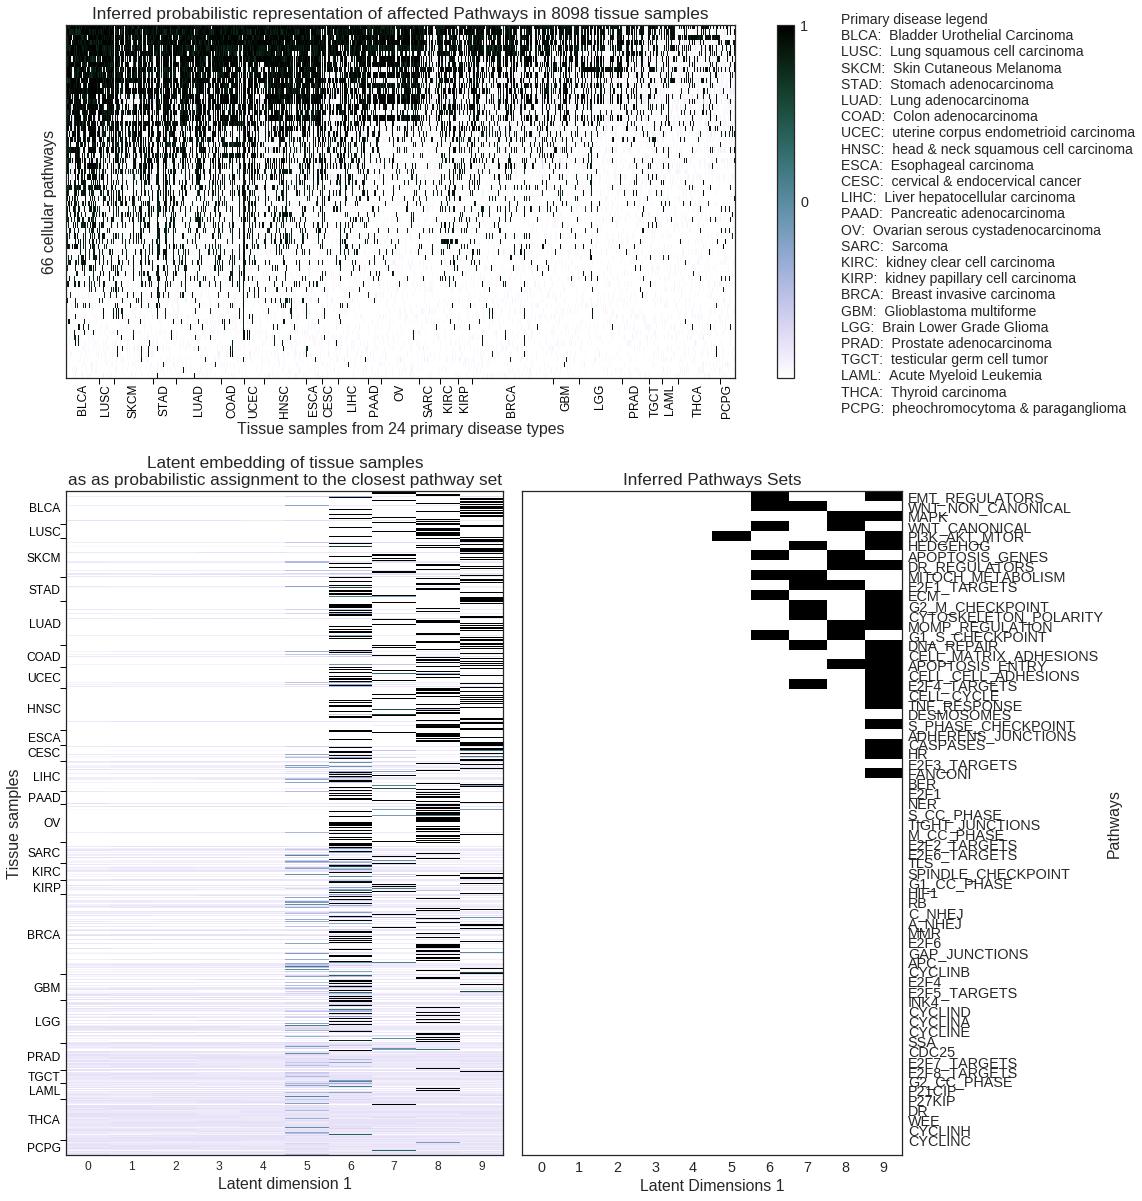

In [142]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=1.4,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=10, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5,
                         z_density_conditions=[1,0,1,0], u_density_conditions=[0,0,2,0]) # [1,0,0,0], [0,1,3,0] is nice

orm_2.infer(burn_in_min=100, burn_in_max=int(1e3), convergence_window=15,
          convergence_eps=2e-4, no_samples=int(5e1), print_step=5, fix_lbda_iters=30)

import tammo_lib as tl
reload(tl)
fig, ax = tl.pancan_pws_1layer(
    patient_pws_2, layer1_2, layer2_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)

now allow each pw to appear 3 times

burning in markov chain...
	iteration: 940 recon acc.: 0.978, 0.843
	converged at reconstr. accuracy: 0.978, 0.843
allocating memory to save samples...
drawing samples...
	iteration 50; recon acc.: 0.98, 0.8379
finished.


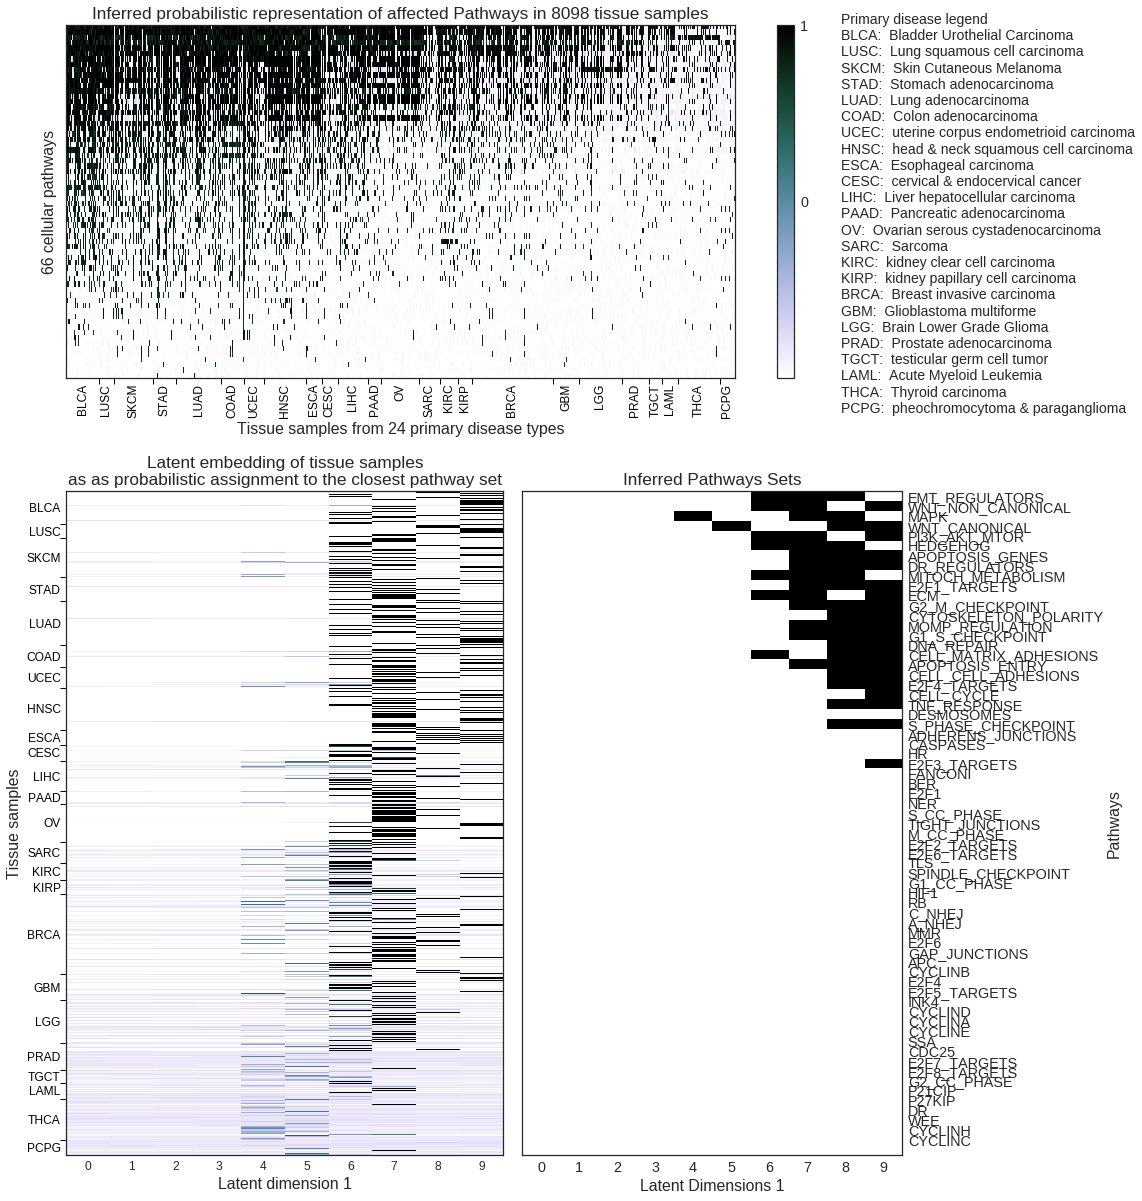

In [145]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=1.4,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=10, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5,
                         z_density_conditions=[1,0,1,0], u_density_conditions=[0,0,3,0]) # [1,0,0,0], [0,1,3,0] is nice

orm_2.infer(burn_in_min=100, burn_in_max=int(1e3), convergence_window=15,
          convergence_eps=2e-4, no_samples=int(5e1), print_step=5, fix_lbda_iters=30)

import tammo_lib as tl
reload(tl)
fig, ax = tl.pancan_pws_1layer(
    patient_pws_2, layer1_2, layer2_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)

burning in markov chain...
	iteration: 2675 recon acc.: 0.992, 0.851
	converged at reconstr. accuracy: 0.992, 0.851
allocating memory to save samples...
drawing samples...
	iteration 100; recon acc.: 0.992, 0.852
finished.


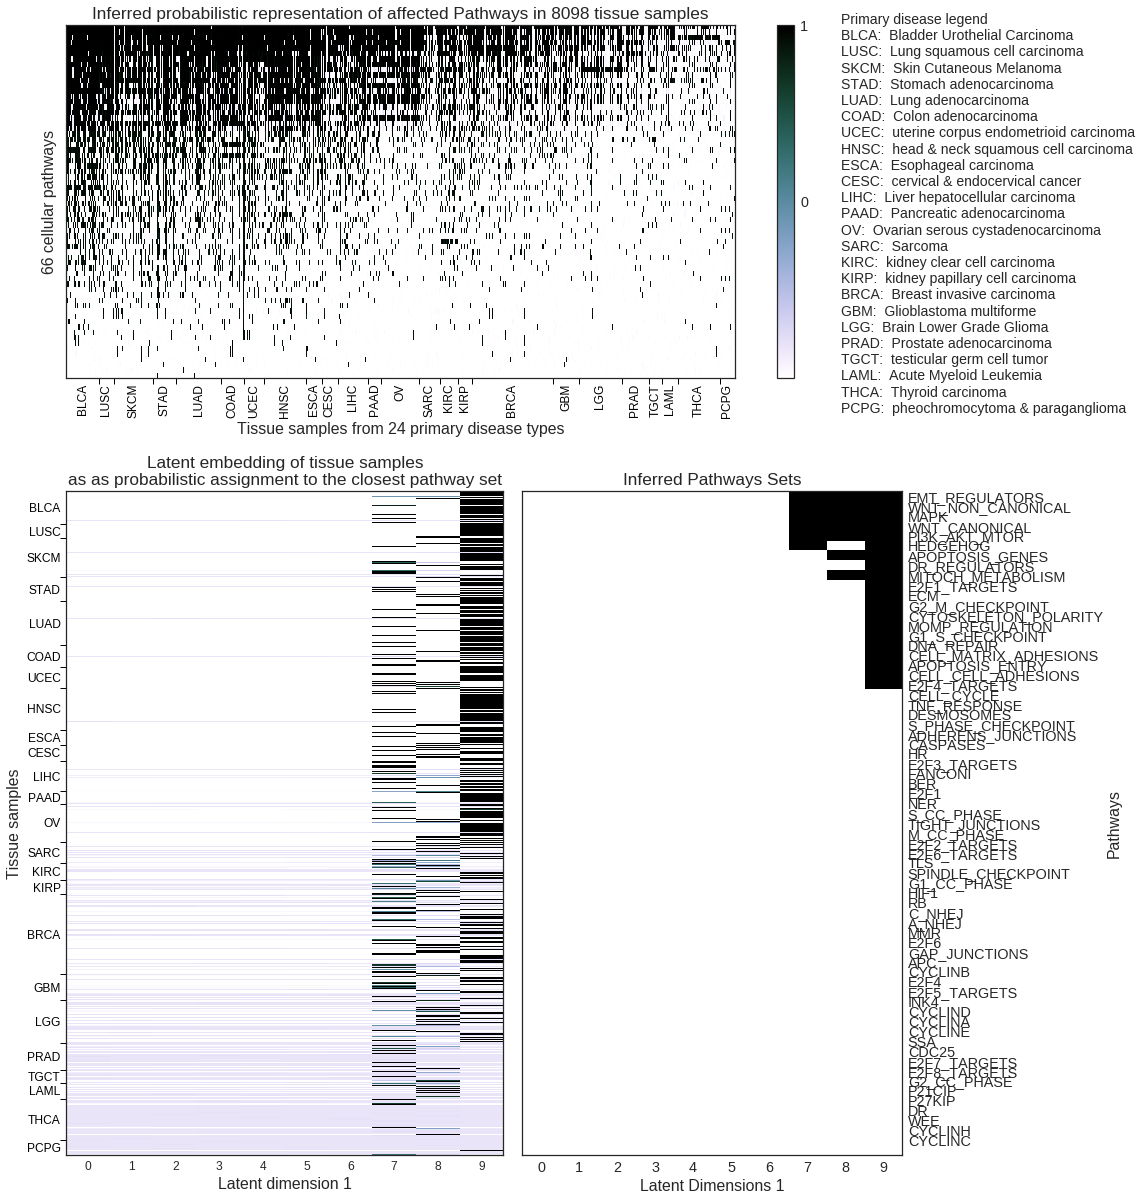

In [148]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=1.4,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=10, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5, u_init=0,
                         z_density_conditions=[1,0,1,0], u_density_conditions=[0,0,3,0]) # [1,0,0,0], [0,1,3,0] is nice

orm_2.infer(burn_in_min=5e2, burn_in_max=int(5e3), convergence_window=15,
          convergence_eps=5e-5, no_samples=int(1e2), print_step=5, fix_lbda_iters=100)

import tammo_lib as tl
reload(tl)
fig, ax = tl.pancan_pws_1layer(
    patient_pws_2, layer1_2, layer2_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)

## restrictions on supervised analysis

In [143]:
reload(ormachine)

# create machine instance
orm_2 = ormachine.machine()

# add patient-pathway matrix
patient_pws_2 = orm_2.add_matrix(shape=(genotype.shape[1], 
                             pathways.shape[0]), 
                             sampling_indicator=True, 
                             p_init=.5)

# add genotype pathway layer
layer1_2 = orm_2.add_layer(child = patient_pws_2, 
                       lbda_init=2.0,
                       z_init=np.array(2*genotype.as_matrix().transpose()-1, dtype=np.int8),
                       u_init=np.array(2*pathways.as_matrix()-1, dtype=np.int8))
layer1_2.z.sampling_indicator = False
layer1_2.u.sampling_indicator = False

# add latent layer wit one hot z (zmin_row=zmax_row=1)
layer2_2 = orm_2.add_layer(size=25, child=patient_pws_2, lbda_init=1.6, u_prior=.5, z_prior=.5,
                         z_density_conditions=[0,0,0,0], u_density_conditions=[0,0,0,0])


# add disease encoding layer
layer3_2 = orm_2.add_layer(child=layer2_2.z, 
                       z_init=np.array(2*labels.as_matrix().transpose()-1, dtype=np.int8),
                       lbda_init=2.0)
layer3_2.z.sampling_indicator = False

orm_2.infer(burn_in_min=60, burn_in_max=int(1e3), convergence_window=15,
          convergence_eps=1e-4, no_samples=int(5e1), print_step=5, fix_lbda_iters=100)

burning in markov chain...
	iteration: 10 recon acc.: 0.881, 0.832, 0.881

KeyboardInterrupt: 

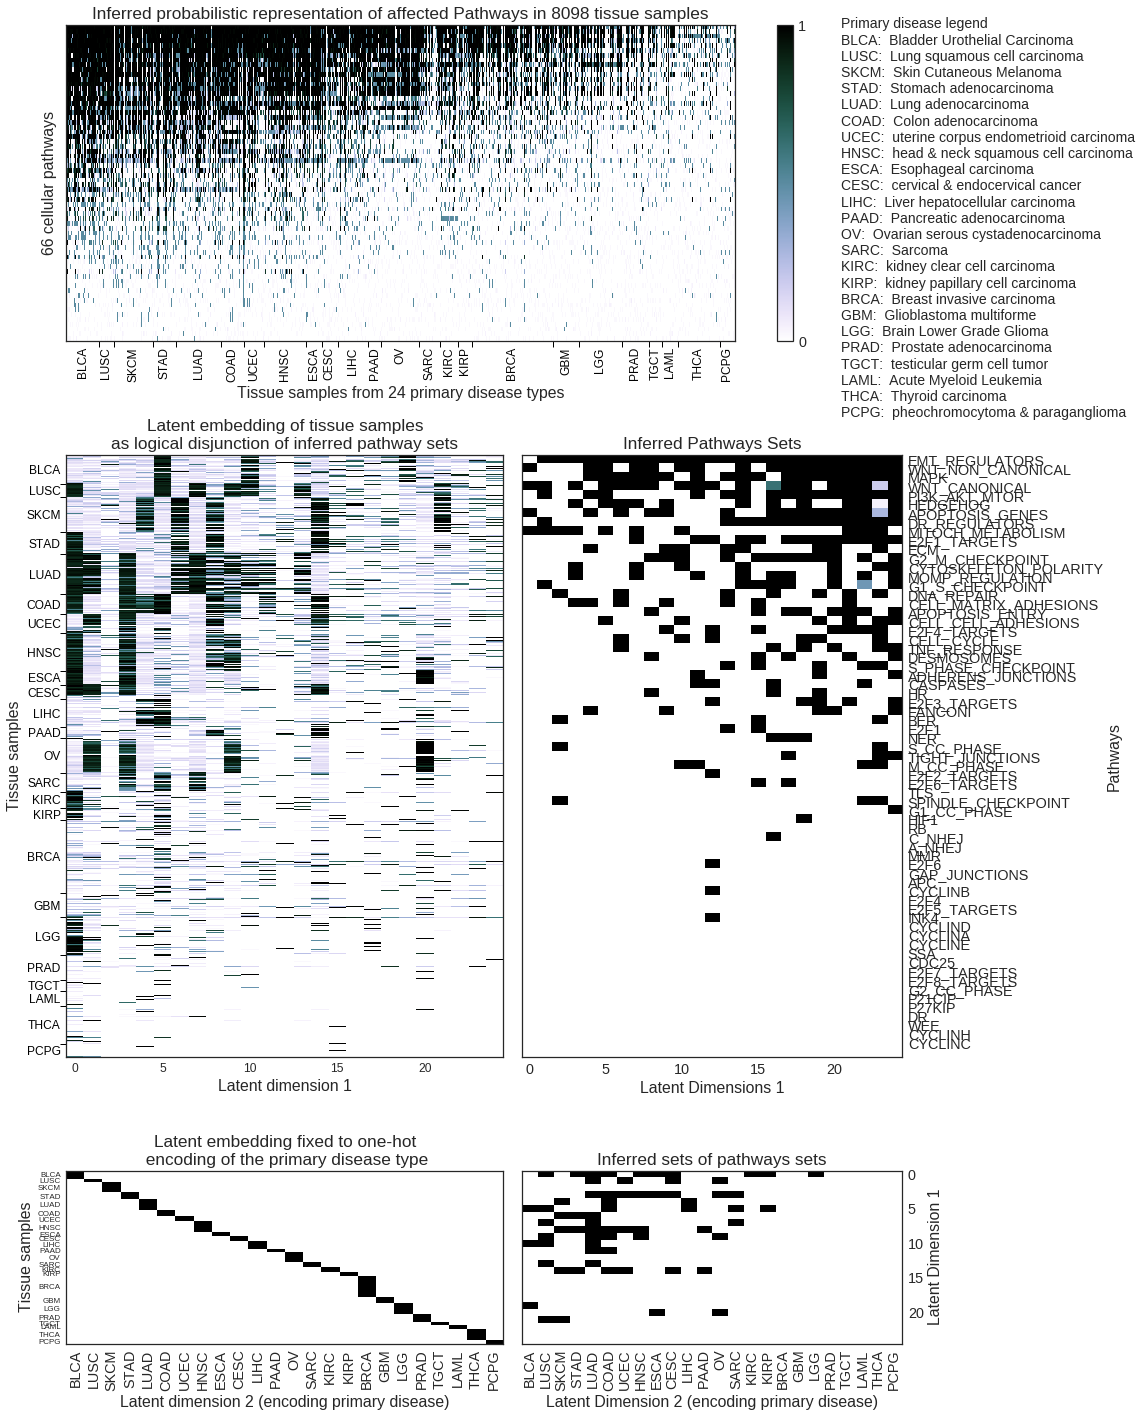

In [136]:
import tammo_lib as tl
reload(tl)
fig = tl.pancan_pws_2layer(
    patient_pws_2, layer2_2, layer3_2,
    labels_samples = pw_sample.columns, 
    labels_pws = pw_sample.index,
    dis_abbrev = [x for y in list(pw_sample.columns.unique()) for x in dis_abbrev if x[1] == y],
    u1_lim=66)